### Table of Contents <a id='toc'></a>

#### 1. [Introduction](#intro)
#### 2. [Load and Clean Dataset](#load_clean)
#### 3. [Exploratory Data Analysis](#explore)
#### 4. [Feature Engineering](#feature_engineering)
#### 5. [Modeling](#modeling)
#### 6. [Final Steps](#final)

# Introduction - Sparkify Project Workspace<a id='intro'></a>

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf

import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
.builder \
.appName("sparkify") \
.getOrCreate()

In [3]:
spark

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'sparkify'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '52255'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '192.168.0.3'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1575811330048')]

# Load and Clean Dataset<a id='load_clean'></a>
[back](#toc)

In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# read sparkify data set
data = spark.read.json('mini_sparkify_event_data.json')

In [6]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [8]:
data.count()

286500

In [9]:
data.filter(data.userId=="").count() # check for missing userId-Data

8346

In [10]:
df = data.filter(data.userId!="") # create data, only with valid userId's

In [11]:
df.count()

278154

In [12]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [13]:
df.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [14]:
df.filter(df.page=="Cancellation Confirmation").select("userId").show(5)

+------+
|userId|
+------+
|    18|
|    32|
|   125|
|   105|
|    17|
+------+
only showing top 5 rows



In [15]:
# transform ts into human readable time format
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts))

In [16]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 02:01:57')

# Exploratory Data Analysis<a id='explore'></a>
[back](#toc)

When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [17]:
# add a churn column for users used the "Cancellation Confirmation" page
churn_users = df.filter(df.page=='Cancellation Confirmation').select('userId').dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df_c = df.withColumn('churn', df.userId.isin(churn_users_list))

In [18]:
df_c.filter(df_c['churn']==True).select('userId', 'time', 'page').show(5)

+------+-------------------+---------+
|userId|               time|     page|
+------+-------------------+---------+
|    54|2018-10-01 02:32:10| NextSong|
|    54|2018-10-01 02:36:20| NextSong|
|    54|2018-10-01 02:39:56| NextSong|
|    54|2018-10-01 02:45:39| NextSong|
|    54|2018-10-01 02:45:49|Downgrade|
+------+-------------------+---------+
only showing top 5 rows



In [19]:
#show some data of a user who churned
df_c.filter(df_c['userId']=='54').select('page', 
                                          'time', 
                                          'level', 
                                          'status', 
                                          'method', 
                                          'churn',
                                          'itemInSession',
                                          'sessionId',
                                          'length').show(20)

+---------+-------------------+-----+------+------+-----+-------------+---------+---------+
|     page|               time|level|status|method|churn|itemInSession|sessionId|   length|
+---------+-------------------+-----+------+------+-----+-------------+---------+---------+
| NextSong|2018-10-01 02:32:10| paid|   200|   PUT| true|            0|       53|250.93179|
| NextSong|2018-10-01 02:36:20| paid|   200|   PUT| true|            1|       53|  216.842|
| NextSong|2018-10-01 02:39:56| paid|   200|   PUT| true|            2|       53|343.32689|
| NextSong|2018-10-01 02:45:39| paid|   200|   PUT| true|            3|       53|246.25587|
|Downgrade|2018-10-01 02:45:49| paid|   200|   GET| true|            4|       53|     null|
| NextSong|2018-10-01 02:49:45| paid|   200|   PUT| true|            5|       53|269.03465|
| NextSong|2018-10-01 02:54:14| paid|   200|   PUT| true|            6|       53|243.04281|
|Thumbs Up|2018-10-01 02:54:15| paid|   307|   PUT| true|            7|       53

#### Gender

In [20]:
gender = df_c.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().sort('churn').toPandas()

In [21]:
gender

,churn,gender,count
0,False,M,89
1,False,F,84
2,True,F,20
3,True,M,32


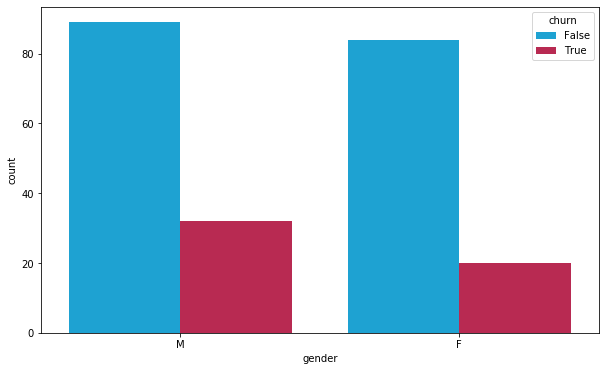

In [22]:
colors = sns.color_palette(['#00b0f0', '#cf1348'])

fig, axs = plt.subplots(figsize=(10,6))

axs = sns.barplot(x='gender',
                 y='count',
                 hue='churn',
                 data=gender,
                 palette=colors,
                 ci=None)

It seems, gender could be a feature for predicting churn, because more men churned.

#### Average Number of used Next Song

In [23]:
songs = df_c.where('page == "NextSong"') \
.groupby(['churn', 'userId', 'sessionId']) \
.count()  \
.groupby(['churn', 'userId']) \
.agg({'count':'avg'}) \
.withColumnRenamed('avg(count)', 'avg_songs_played') \
.toPandas()

In [24]:
songs.head()

,churn,userId,avg_songs_played
0,False,114,80.750000
1,False,39,77.689320
2,True,103,107.300000
3,True,12,96.333333
4,False,200012,33.000000


Text(0.5, 0, 'Average Number of Songs per Session')

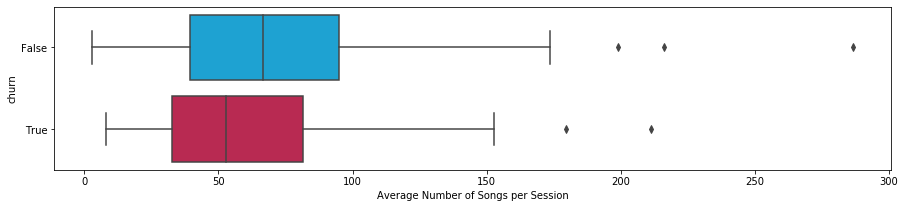

In [25]:
fig, axs = plt.subplots(figsize=(15,3))
axs = sns.boxplot(x='avg_songs_played',
                  y='churn',
                  data=songs,
                  palette=colors,
                  orient='h')
axs.set_xlabel('Average Number of Songs per Session')

#### Paid or Free users

In [26]:
level = df_c \
    .dropDuplicates(['userId', 'level']) \
    .groupby(['churn', 'level']) \
    .count() \
    .sort('churn') \
    .toPandas()

In [27]:
level

,churn,level,count
0,False,free,149
1,False,paid,129
2,True,paid,36
3,True,free,46


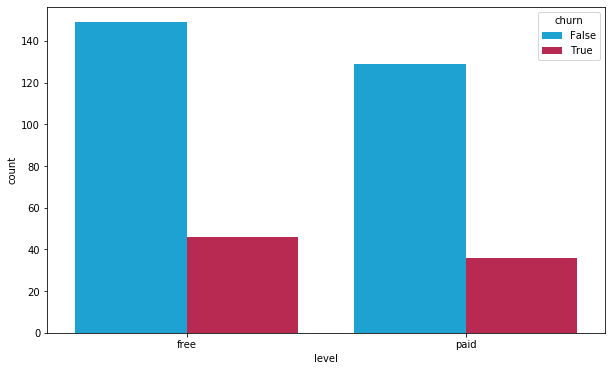

In [28]:
fig, axs = plt.subplots(figsize=(10,6))

axs = sns.barplot(x='level',
                 y='count',
                 hue='churn',
                 data=level,
                 palette=colors,
                 ci=None)

#### Number of listened Songs

In [29]:
songs_listened = df_c \
    .select('userId','song', 'churn') \
    .groupBy('userId', 'churn') \
    .count() \
    .toPandas()

In [30]:
songs_listened.head()

,userId,churn,count
0,19,False,259
1,100005,True,216
2,200007,False,76
3,300007,True,143
4,50,False,651


Text(0.5, 0, 'Total Songs listened')

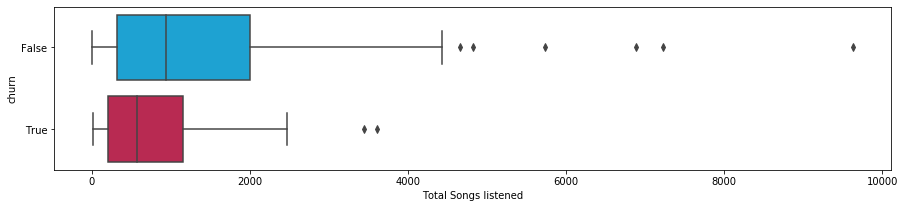

In [31]:
fig, axs = plt.subplots(figsize=(15,3))
axs = sns.boxplot(x='count',
                  y='churn',
                  data=songs_listened,
                  palette=colors,
                  orient="h")
axs.set_xlabel('Total Songs listened')

#### Number of different Artist listened

In [32]:
artists = df_c \
    .select("userId", "artist", 'churn') \
    .dropDuplicates() \
    .groupby("userId", 'churn') \
    .count() \
    .toPandas()

In [33]:
artists.head()

,userId,churn,count
0,19,False,198
1,200007,False,65
2,100005,True,150
3,300007,True,108
4,50,False,424


Text(0.5, 0, 'Total Artists listened')

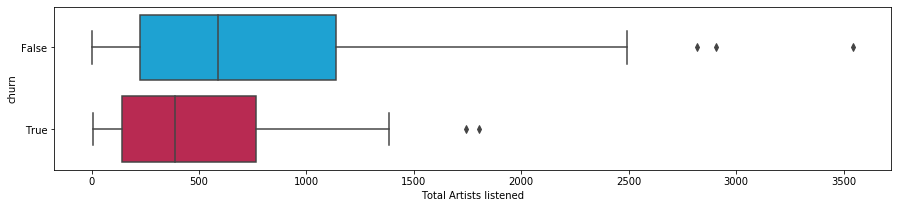

In [34]:
fig, axs = plt.subplots(figsize=(15,3))
axs = sns.boxplot(x='count',
                  y='churn',
                  data=artists,
                  palette=colors,
                  orient="h")
axs.set_xlabel('Total Artists listened')

#### Number of Sessions

In [35]:
n_sessions = df_c \
    .select('userId','sessionId', 'churn') \
    .groupBy('userId', 'churn') \
    .count() \
    .toPandas()

In [36]:
n_sessions.head()

,userId,churn,count
0,19,False,259
1,100005,True,216
2,200007,False,76
3,300007,True,143
4,50,False,651


Text(0.5, 0, 'Number of total Sessions')

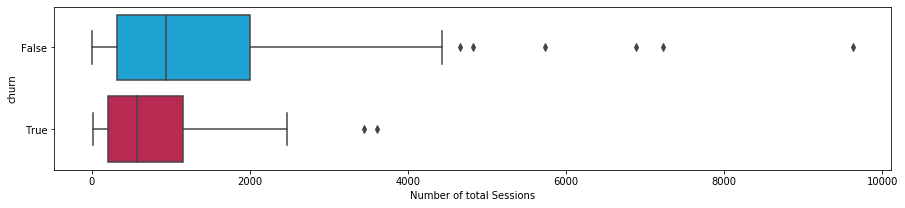

In [37]:
fig, axs = plt.subplots(figsize=(15,3))
axs = sns.boxplot(x='count',
                  y='churn',
                  data=n_sessions,
                  palette=colors,
                  orient="h")
axs.set_xlabel('Number of total Sessions')

Ok it seems, this is the same as Number of listened Songs.

#### Total length

In [38]:
length = df_c \
    .select('userId','length', 'churn') \
    .groupBy('userId', 'churn') \
    .sum() \
    .toPandas()

In [39]:
length.head()

,userId,churn,sum(length)
0,19,False,54480.93387
1,100005,True,37037.12201
2,200007,False,15739.86931
3,300007,True,28028.71048
4,50,False,122751.27561


Text(0.5, 0, 'Length (Sum)')

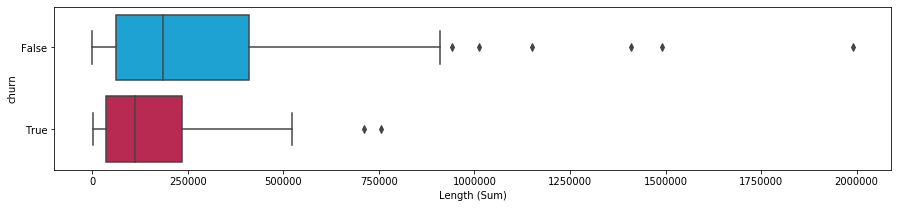

In [40]:
fig, axs = plt.subplots(figsize=(15,3))
axs = sns.boxplot(x='sum(length)',
                  y='churn',
                  data=length,
                  palette=colors,
                  orient="h")
axs.set_xlabel('Length (Sum)')

In [41]:
songs_length = songs_listened.merge(length, on='userId')

Text(0, 0.5, 'Number of Songs listened')

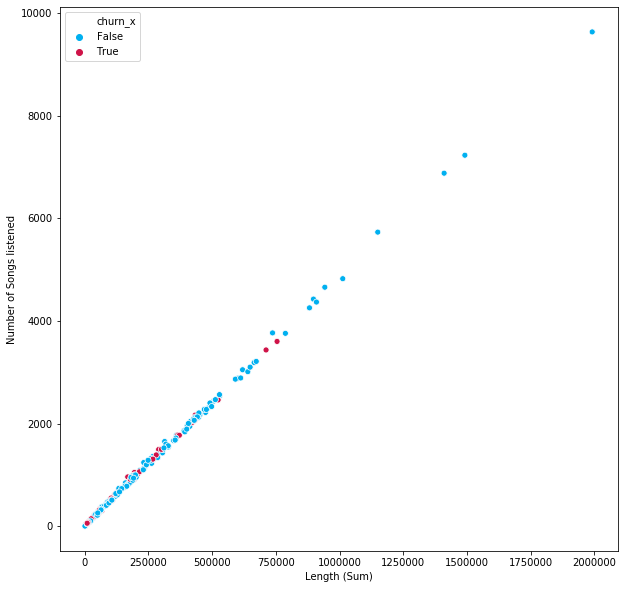

In [43]:
fig, axs = plt.subplots(figsize=(10,10))
axs = sns.scatterplot(x='sum(length)',
                      y='count',
                      hue='churn_x',
                      data=songs_length,
                      palette=colors)
axs.set_xlabel('Length (Sum)')
axs.set_ylabel('Number of Songs listened')

That I expected, the length is the length of the songs, so for later on, I should use just one feature length or number of songs listened.

In [ ]:
Thumbs Down|
|           Thumbs Up

In [47]:
thumbs_up = df_c.select('userID', 'churn', 'page') \
    .where(df_c.page == 'Thumbs Up') \
    .groupBy('userID', 'churn') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_up')  \
    .toPandas()

In [48]:
thumbs_up.head()

,userID,churn,num_thumb_up
0,19,False,5
1,100005,True,7
2,200007,False,2
3,300007,True,11
4,50,False,27


Text(0.5, 0, 'Number of "Thumbs Up" per user')

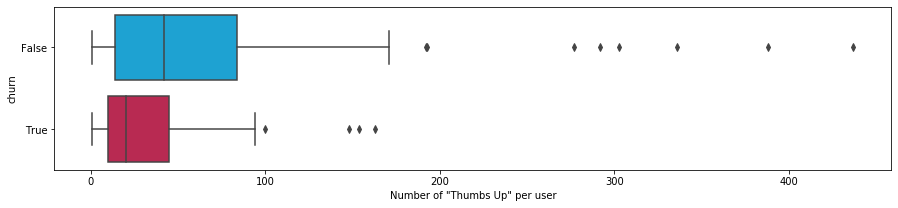

In [49]:
fig, axs = plt.subplots(figsize=(15,3))
axs = sns.boxplot(x='num_thumb_up',
                  y='churn',
                  data=thumbs_up,
                  palette=colors,
                  orient="h")
axs.set_xlabel('Number of "Thumbs Up" per user')

Ok number of "thumbs up" per User could be a feature. Users who churned have less often pressed thumbs up.

In [50]:
thumbs_down = df_c.select('userID', 'churn', 'page') \
    .where(df_c.page == 'Thumbs Down') \
    .groupBy('userID', 'churn') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_down')  \
    .toPandas()

In [52]:
thumbs_down.head()

,userID,churn,num_thumb_down
0,19,False,2
1,100005,True,3
2,300007,True,1
3,50,False,3
4,200002,False,6


Text(0.5, 0, 'Number of "Thumbs Down" per user')

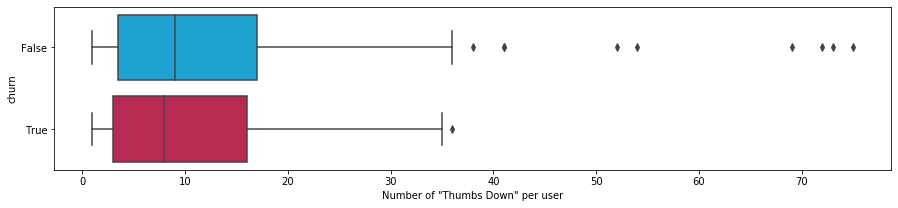

In [54]:
fig, axs = plt.subplots(figsize=(15,3))
axs = sns.boxplot(x='num_thumb_down',
                  y='churn',
                  data=thumbs_down,
                  palette=colors,
                  orient="h")
axs.set_xlabel('Number of "Thumbs Down" per user')

In [56]:
added_friends = df_c.select('userID', 'churn', 'page') \
    .where(df_c.page == 'Add Friend') \
    .groupBy('userID', 'churn') \
    .count() \
    .withColumnRenamed('count', 'num_added_friends')  \
    .toPandas()

In [57]:
added_friends.head()

,userID,churn,num_added_friends
0,19,False,4
1,100005,True,3
2,200007,False,1
3,300007,True,4
4,50,False,9


Text(0.5, 0, 'Number of added friends per user')

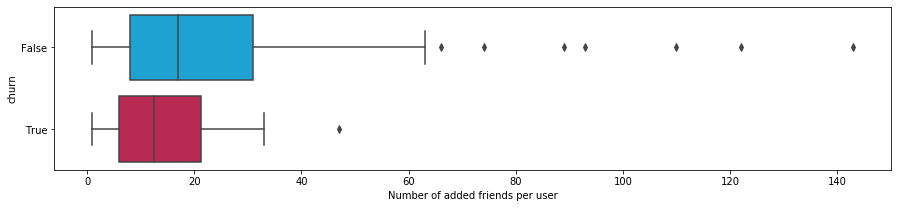

In [59]:
fig, axs = plt.subplots(figsize=(15,3))
axs = sns.boxplot(x='num_added_friends',
                  y='churn',
                  data=added_friends,
                  palette=colors,
                  orient="h")
axs.set_xlabel('Number of added friends per user')

Ok that is also interesting, user who churned not significantly pressed the "thumbs down" button more often than user who not churned.

# Feature Engineering <a id='feature_engineering'></a>
[back](#toc)

Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling <a id='modeling'></a>
[back](#toc)

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps <a id='final'></a>
[back](#toc)

Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.